<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We"re going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you"ll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> Preparing the tools </font></h2>

In [91]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import plotly.express as px

# Set the style
plt.style.use("ggplot")
# plt.style.available

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Zicht op Data dataset </font></h3>

<h4><font color=mediumvioletred>Read CSV files </font></h4>

In [92]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Get a sample </font></h4>

In [93]:
# zichtop sample
df_zichtop.head(10)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
0,5611,2021-01-01 00:00:00,830,136.0,80.0,34.0,57.0,34.0,34.0,455.0
1,5611,2021-01-01 01:00:00,837,138.0,11.0,23.0,92.0,23.0,80.0,470.0
2,5611,2021-01-01 02:00:00,745,41.0,0.0,0.0,82.0,51.0,71.0,500.0
3,5611,2021-01-01 03:00:00,876,115.0,0.0,0.0,52.0,21.0,125.0,563.0
4,5611,2021-01-01 04:00:00,714,49.0,0.0,0.0,37.0,25.0,111.0,492.0
5,5611,2021-01-01 05:00:00,702,28.0,0.0,0.0,0.0,28.0,183.0,463.0
6,5611,2021-01-01 06:00:00,888,53.0,0.0,0.0,18.0,89.0,160.0,568.0
7,5611,2021-01-01 07:00:00,1182,148.0,0.0,0.0,0.0,84.0,169.0,781.0
8,5611,2021-01-01 08:00:00,1263,134.0,38.0,0.0,19.0,115.0,268.0,689.0
9,5611,2021-01-01 09:00:00,1514,214.0,71.0,0.0,71.0,160.0,303.0,695.0


In [94]:
# air_pollution sample
df_air_pollution.sample(5)

,date,PC4,pm10,pm2.5,no2,no,so2
44173,2021-10-26 13:00:00,5653,16.257410,8.985305,17.214553,11.262713,3.297540
71751,2021-12-24 14:00:00,5641,29.604590,46.692060,17.795008,28.319151,0.562355
42117,2021-10-07 21:00:00,5652,35.555859,28.609646,49.667198,32.495028,11.040969
75404,2021-12-29 19:00:00,5617,17.511920,21.063220,17.987361,0.195505,1.878245
17992,2021-10-07 16:00:00,5625,14.382483,7.551966,12.354227,8.082819,0.696638


<h4><font color=mediumvioletred>Get number of rows and columns </font></h4>

In [95]:
df_zichtop.shape

(255024, 10)

<h4><font color=mediumvioletred>Get types of columns </font></h4>

In [96]:
df_zichtop.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
dtype: object

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..) </font></h4>

In [97]:
df_zichtop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PC4      255024 non-null  int64         
 1   date     255024 non-null  datetime64[ns]
 2   pop_tot  255024 non-null  int64         
 3   m00_30   254276 non-null  float64       
 4   m30_60   254276 non-null  float64       
 5   H1_2     254276 non-null  float64       
 6   H2_4     254276 non-null  float64       
 7   H4_8     254276 non-null  float64       
 8   H8_16    254276 non-null  float64       
 9   H16plus  254276 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 19.5 MB


<h4><font color=mediumvioletred>Get some info about numerical columns (count, mean, min...) </font></h4>

In [98]:
df_zichtop.describe()

,PC4,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
count,255024.000000,255024.000000,254276.000000,254276.000000,254276.00000,254276.000000,254276.000000,254276.000000,254276.000000
mean,5633.818182,1984.896131,334.580322,41.012966,73.50676,126.323121,237.291384,349.584455,827.626296
std,15.168687,1285.972747,376.307733,61.055502,104.01577,186.176472,331.758108,380.206726,538.795020
min,5611.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-3.000000
25%,5622.000000,1060.000000,56.000000,0.000000,0.00000,9.000000,38.000000,98.000000,471.000000
50%,5631.000000,1703.000000,222.000000,15.000000,32.00000,62.000000,119.000000,236.000000,781.000000
75%,5646.000000,2615.000000,481.000000,60.000000,107.00000,173.000000,292.000000,454.000000,1093.000000
max,5658.000000,11617.000000,4885.000000,2090.000000,1564.00000,5326.000000,3515.000000,3368.000000,3409.000000


<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets </font></h4>

In [99]:
df_zichtop_air_pollution = pd.merge(df_zichtop, df_air_pollution[["PC4","date", "pm2.5"]], on=["PC4", "date"])
df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,pm2.5
36686,5653,2021-11-07 14:00:00,2009,474.0,72.0,103.0,144.0,196.0,247.0,773.0,4.212838
17062,5626,2021-11-14 22:00:00,1363,60.0,0.0,0.0,0.0,9.0,187.0,1107.0,8.147939
24043,5633,2021-10-06 19:00:00,583,291.0,58.0,0.0,87.0,29.0,117.0,1.0,5.167689
1452,5612,2021-09-30 12:00:00,7513,906.0,261.0,277.0,860.0,2427.0,1890.0,892.0,5.070581
11129,5622,2021-10-18 17:00:00,2299,300.0,100.0,140.0,160.0,80.0,520.0,999.0,8.904518


In [100]:
df_zichtop_air_pollution.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
pm2.5             float64
dtype: object

<h4><font color=mediumvioletred>Reorder columns in zichtop air pollution dataset </font></h4>

In [101]:
zichtop_air_pollution_features = [
    "PC4",
    "date",
    "pop_tot",
    "pm2.5",
    "m00_30",
    "m30_60",
    "H1_2",
    "H2_4",
    "H4_8",
    "H8_16",
    "H16plus"
]

df_zichtop_air_pollution = df_zichtop_air_pollution.reindex(zichtop_air_pollution_features, axis=1)

df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
440,5611,2021-10-13 08:00:00,6581,6.546959,723.0,174.0,506.0,955.0,1953.0,1663.0,607.0
5975,5615,2021-10-23 23:00:00,1026,16.003305,248.0,35.0,0.0,0.0,0.0,35.0,708.0
42517,5658,2021-10-06 13:00:00,2875,5.777953,453.0,68.0,77.0,125.0,164.0,299.0,1689.0
37279,5654,2021-10-08 07:00:00,3430,12.915983,327.0,133.0,121.0,182.0,1479.0,473.0,715.0
16795,5626,2021-11-03 19:00:00,2222,21.839800,352.0,21.0,139.0,117.0,64.0,513.0,1016.0


<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [102]:
df_zichtop_air_pollution.rename(columns={"date": "date_time"}, inplace=True)

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [103]:
df_zichtop_air_pollution["date"] = df_zichtop_air_pollution["date_time"].dt.date.astype(str)
df_zichtop_air_pollution["time"] = df_zichtop_air_pollution["date_time"].dt.time.astype(str)

In [104]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
21828,5631,2021-10-24 12:00:00,3466,4.851183,1220.0,106.0,354.0,477.0,460.0,407.0,442.0,2021-10-24,12:00:00
43495,5658,2021-11-16 07:00:00,2605,40.738152,204.0,33.0,59.0,33.0,197.0,467.0,1612.0,2021-11-16,07:00:00
34540,5652,2021-10-04 04:00:00,3891,2.594182,497.0,50.0,12.0,62.0,274.0,1069.0,1927.0,2021-10-04,04:00:00
11676,5622,2021-11-10 12:00:00,2090,21.666246,397.0,82.0,47.0,140.0,292.0,385.0,747.0,2021-11-10,12:00:00
12253,5623,2021-10-10 13:00:00,3689,19.251701,804.0,144.0,144.0,536.0,639.0,680.0,742.0,2021-10-10,13:00:00


<h4><font color=mediumvioletred>Correlation between numerical columns </font></h4>

In [105]:
df_zichtop_air_pollution.corr()

,PC4,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
PC4,1.000000,-0.085402,-0.040311,0.050393,-0.068758,-0.123084,-0.137336,-0.118519,-0.033977,-0.052989
pop_tot,-0.085402,1.000000,-0.016892,0.750560,0.708953,0.749542,0.761389,0.815847,0.842051,0.199654
pm2.5,-0.040311,-0.016892,1.000000,-0.094783,-0.025442,-0.015412,-0.017758,0.005160,0.018352,0.025760
m00_30,0.050393,0.750560,-0.094783,1.000000,0.640048,0.621415,0.589695,0.550787,0.616381,-0.189647
m30_60,-0.068758,0.708953,-0.025442,0.640048,1.000000,0.749745,0.676787,0.609642,0.572131,-0.137459
H1_2,-0.123084,0.749542,-0.015412,0.621415,0.749745,1.000000,0.805084,0.656044,0.571656,-0.132161
H2_4,-0.137336,0.761389,-0.017758,0.589695,0.676787,0.805084,1.000000,0.724193,0.540605,-0.144004
H4_8,-0.118519,0.815847,0.005160,0.550787,0.609642,0.656044,0.724193,1.000000,0.692728,-0.154635
H8_16,-0.033977,0.842051,0.018352,0.616381,0.572131,0.571656,0.540605,0.692728,1.000000,-0.002266
H16plus,-0.052989,0.199654,0.025760,-0.189647,-0.137459,-0.132161,-0.144004,-0.154635,-0.002266,1.000000


<h4><font color=mediumvioletred>Visualize correlation between numerical columns </font></h4>

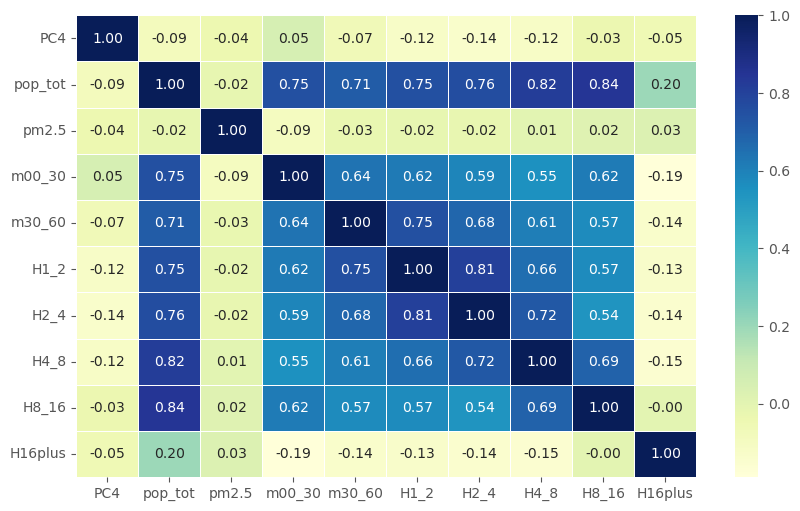

In [106]:
corr_matrix = df_zichtop_air_pollution.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

<h4><font color=mediumvioletred>Get number of people in zipcode 5611 on 2021-09-25 </font></h4>

In [107]:
people_air_quality_area = df_zichtop_air_pollution[(df_zichtop_air_pollution["PC4"] == 5611) & (df_zichtop_air_pollution["date"] == "2021-09-25")]
people_air_quality_area.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
10,5611,2021-09-25 10:00:00,7255,7.943402,1133.0,413.0,658.0,1776.0,980.0,1010.0,1285.0,2021-09-25,10:00:00
0,5611,2021-09-25 00:00:00,1438,4.531522,155.0,0.0,0.0,0.0,0.0,77.0,1206.0,2021-09-25,00:00:00
9,5611,2021-09-25 09:00:00,5693,9.297590,631.0,166.0,880.0,963.0,913.0,1029.0,1111.0,2021-09-25,09:00:00
23,5611,2021-09-25 23:00:00,2560,11.110579,140.0,14.0,28.0,210.0,406.0,490.0,1272.0,2021-09-25,23:00:00
17,5611,2021-09-25 17:00:00,6937,13.358345,756.0,145.0,524.0,1105.0,2051.0,1425.0,931.0,2021-09-25,17:00:00


<h4><font color=mediumvioletred>Visualize number of people in zipcode 5611 on 2021-09-25 </font></h4>

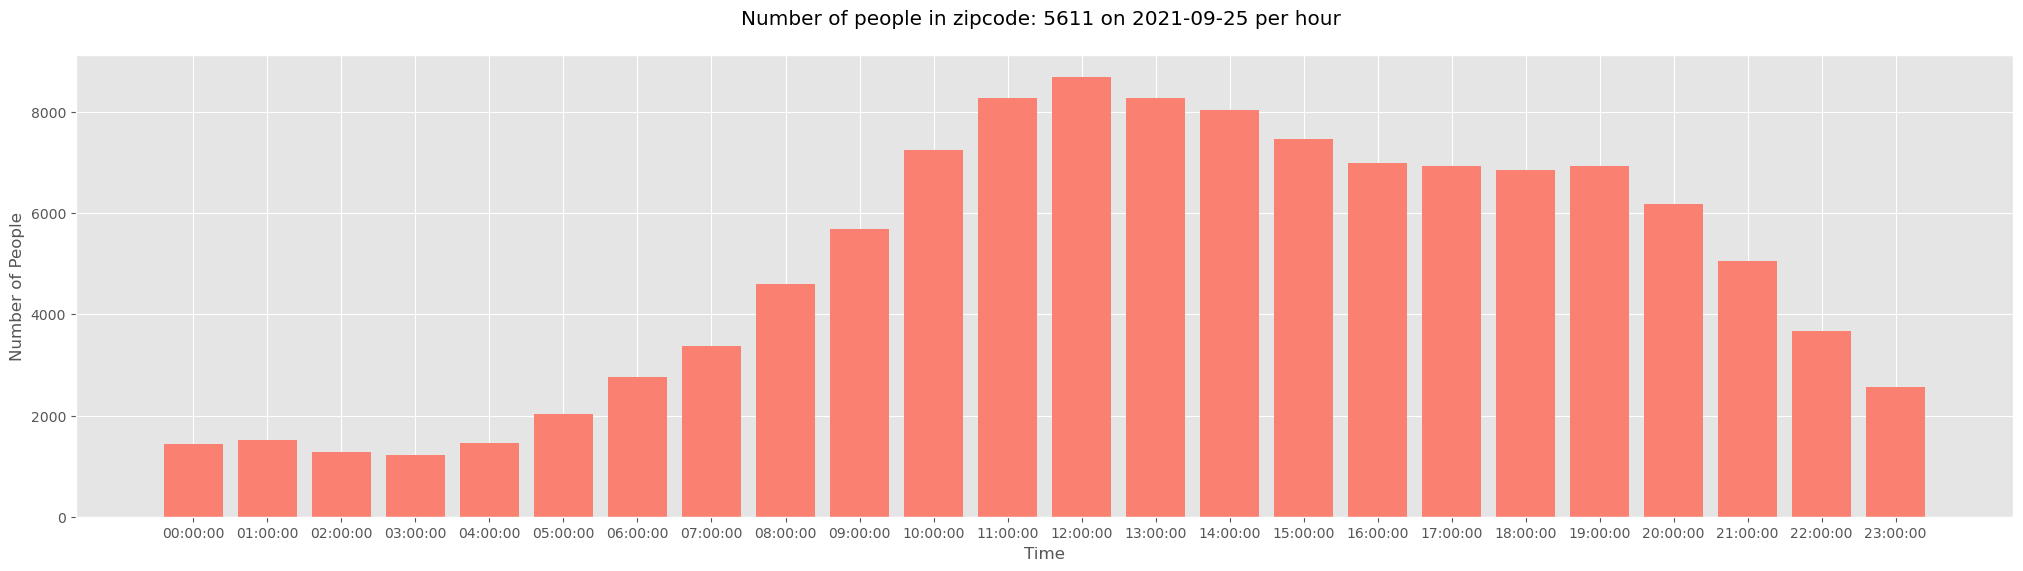

In [108]:
fig, ax = plt.subplots(figsize=(25, 6))
# Plot the data
scatter = ax.bar(list(people_air_quality_area["time"]),
                list(people_air_quality_area["pop_tot"]),
                color="salmon");

# Customize the plot
ax.set(title="Number of people in zipcode: 5611 on 2021-09-25 per hour \n",
      xlabel="Time",
      ylabel="Number of People");

<h4><font color=mediumvioletred> Get maximum number of people per zipcode </font></h4>

In [109]:
max_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg("max").reset_index()
max_people.head()

,PC4,pop_tot
0,5611,11617
1,5612,10250
2,5613,5925
3,5614,3504
4,5615,4408


<h4><font color=mediumvioletred> Visualize maximum number of people per zipcode </font></h4>

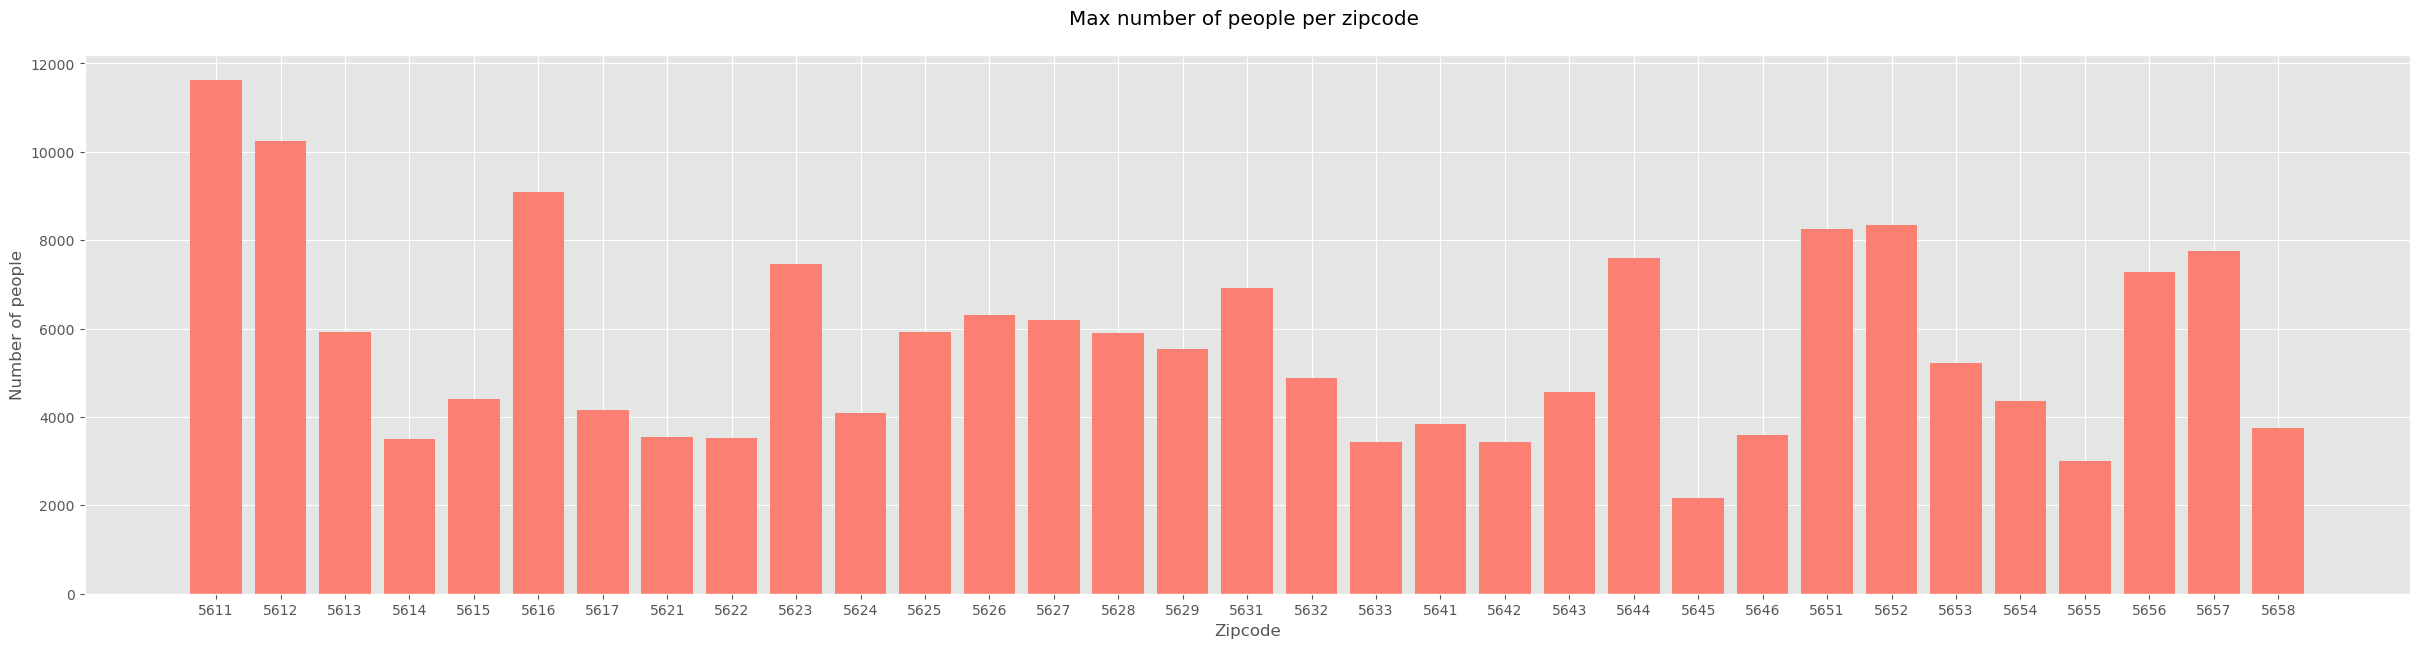

In [110]:
fig, ax = plt.subplots(figsize=(30, 7))
# Plot the data
scatter = ax.bar(max_people["PC4"].astype(str),
                max_people["pop_tot"],
                color="salmon");

# Customize the plot
ax.set(title="Max number of people per zipcode \n",
      xlabel="Zipcode",
      ylabel="Number of people");

Zipcodes 5611, 5612, 5616 have the highest number of people.

<h4><font color=mediumvioletred> Get maximum, average and minimum number of people per zipcode </font></h4>

In [111]:
max_mean_min_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_people.head()

,PC4,max,min,mean
0,5611,11617,708,4676.526515
1,5612,10250,737,4052.258333
2,5613,5925,537,2504.754545
3,5614,3504,217,1509.311364
4,5615,4408,394,1933.862121


<h4><font color=mediumvioletred> Visualize maximum, average and minimum number of people per zipcode </font></h4>

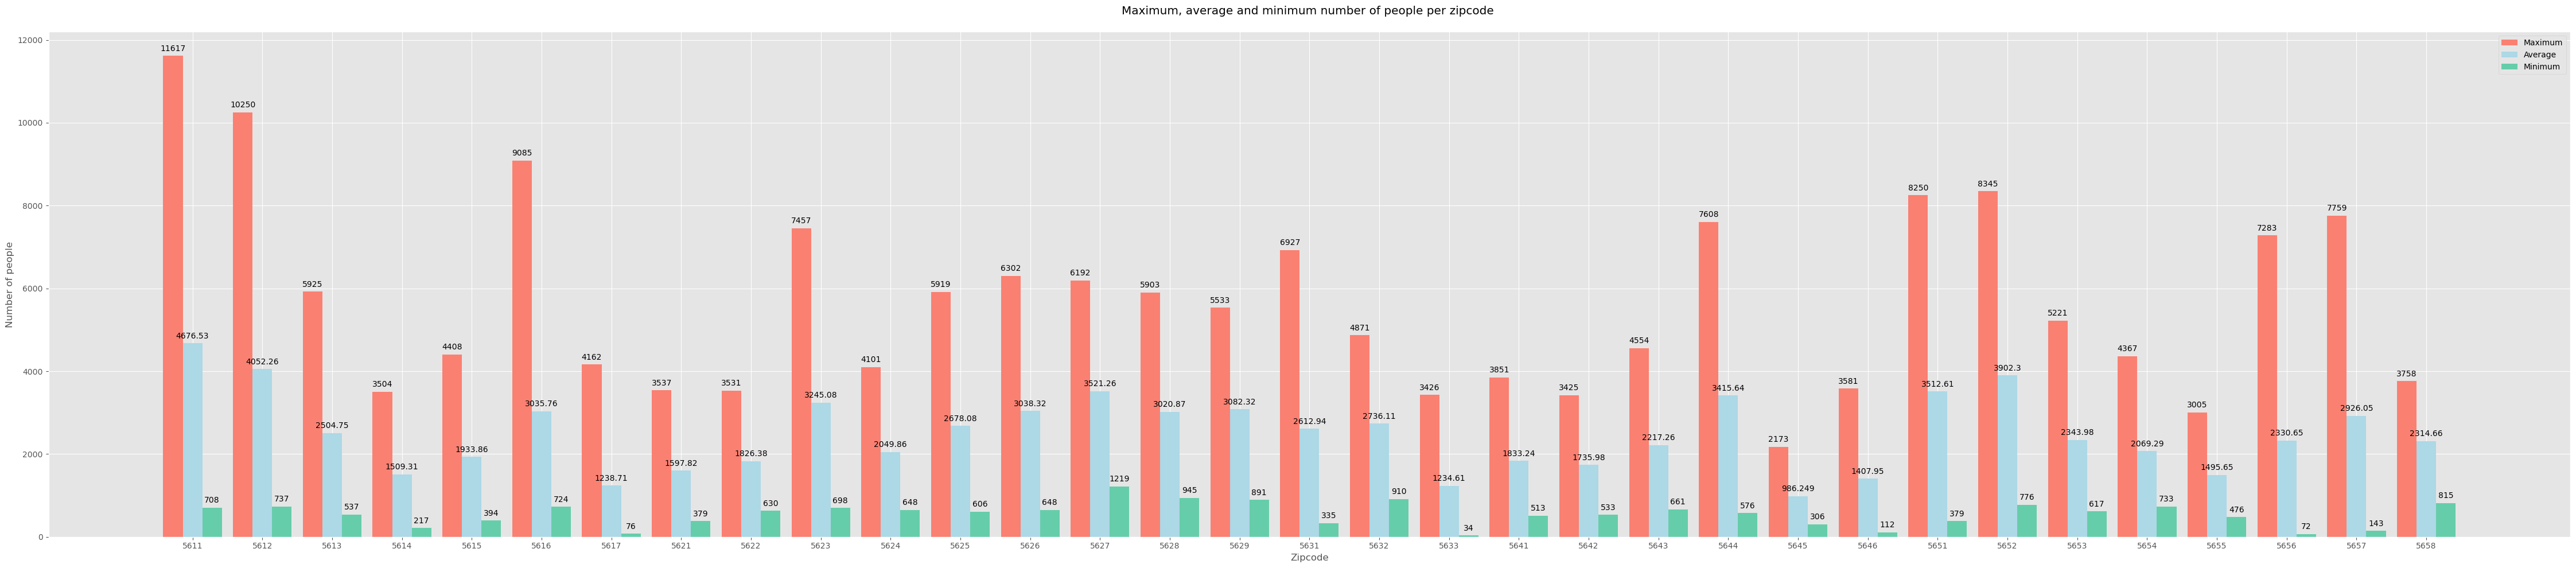

In [112]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_people["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, max_mean_min_people["max"], width, label="Maximum", color="salmon")
rects2 = ax.bar(x, max_mean_min_people["mean"], width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, max_mean_min_people["min"], width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Number of people")
ax.set_xlabel("Zipcode")
ax.set_title("Maximum, average and minimum number of people per zipcode \n")
ax.set_xticks(x, max_mean_min_people["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

plt.show()

Zipcodes 5611, 5612, 5616 have the highest number of people and zipcodes 5633, 5656, 5617 have the lowest number of people.

<h4><font color=mediumvioletred> Get number of people vs. air quality </font></h4>

In [113]:
# get data for zipcode 5611 on 2021-09-25
people_air_quality_area.head(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
0,5611,2021-09-25 00:00:00,1438,4.531522,155.0,0.0,0.0,0.0,0.0,77.0,1206.0,2021-09-25,00:00:00
1,5611,2021-09-25 01:00:00,1516,3.434374,130.0,0.0,0.0,0.0,29.0,72.0,1285.0,2021-09-25,01:00:00
2,5611,2021-09-25 02:00:00,1283,4.274056,44.0,0.0,0.0,0.0,15.0,73.0,1151.0,2021-09-25,02:00:00
3,5611,2021-09-25 03:00:00,1223,5.396931,14.0,0.0,0.0,14.0,14.0,86.0,1095.0,2021-09-25,03:00:00
4,5611,2021-09-25 04:00:00,1464,6.389200,56.0,0.0,14.0,28.0,28.0,155.0,1183.0,2021-09-25,04:00:00


<h4><font color=mediumvioletred> Visualize number of people vs. air quality </font></h4>

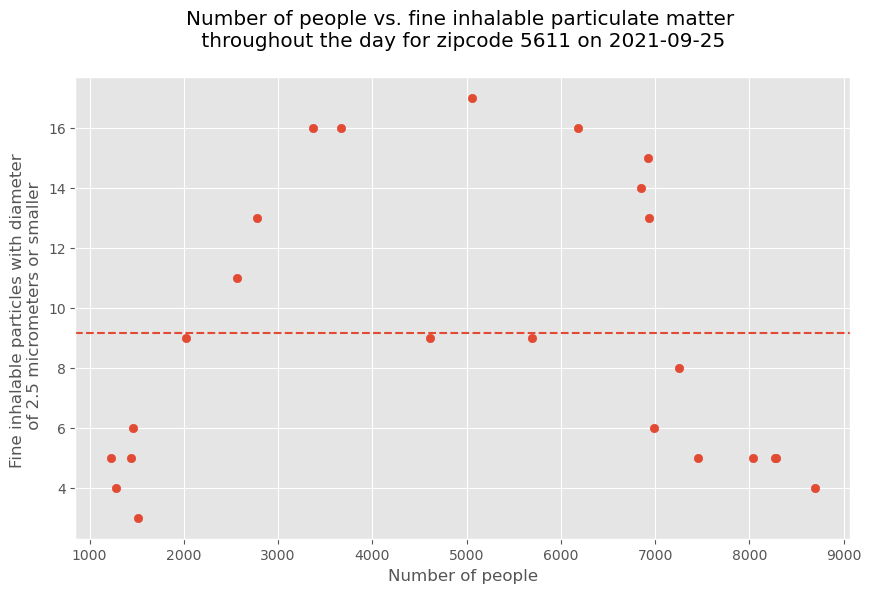

In [114]:
# Number of people vs. fine particulate matter in a day in a specific area
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
scatter = ax.scatter(x=people_air_quality_area["pop_tot"],
                    y=round(people_air_quality_area["pm2.5"]),
                    cmap="winter"); # color map: this changes the color scheme

# Customize the plot
ax.set(title="Number of people vs. fine inhalable particulate matter \n throughout the day for zipcode 5611 on 2021-09-25 \n",
      xlabel="Number of people",
      ylabel="Fine inhalable particles with diameter \n of 2.5 micrometers or smaller");

# Add a horizontal line
ax.axhline(people_air_quality_area["pm2.5"].mean(),
          linestyle="--");

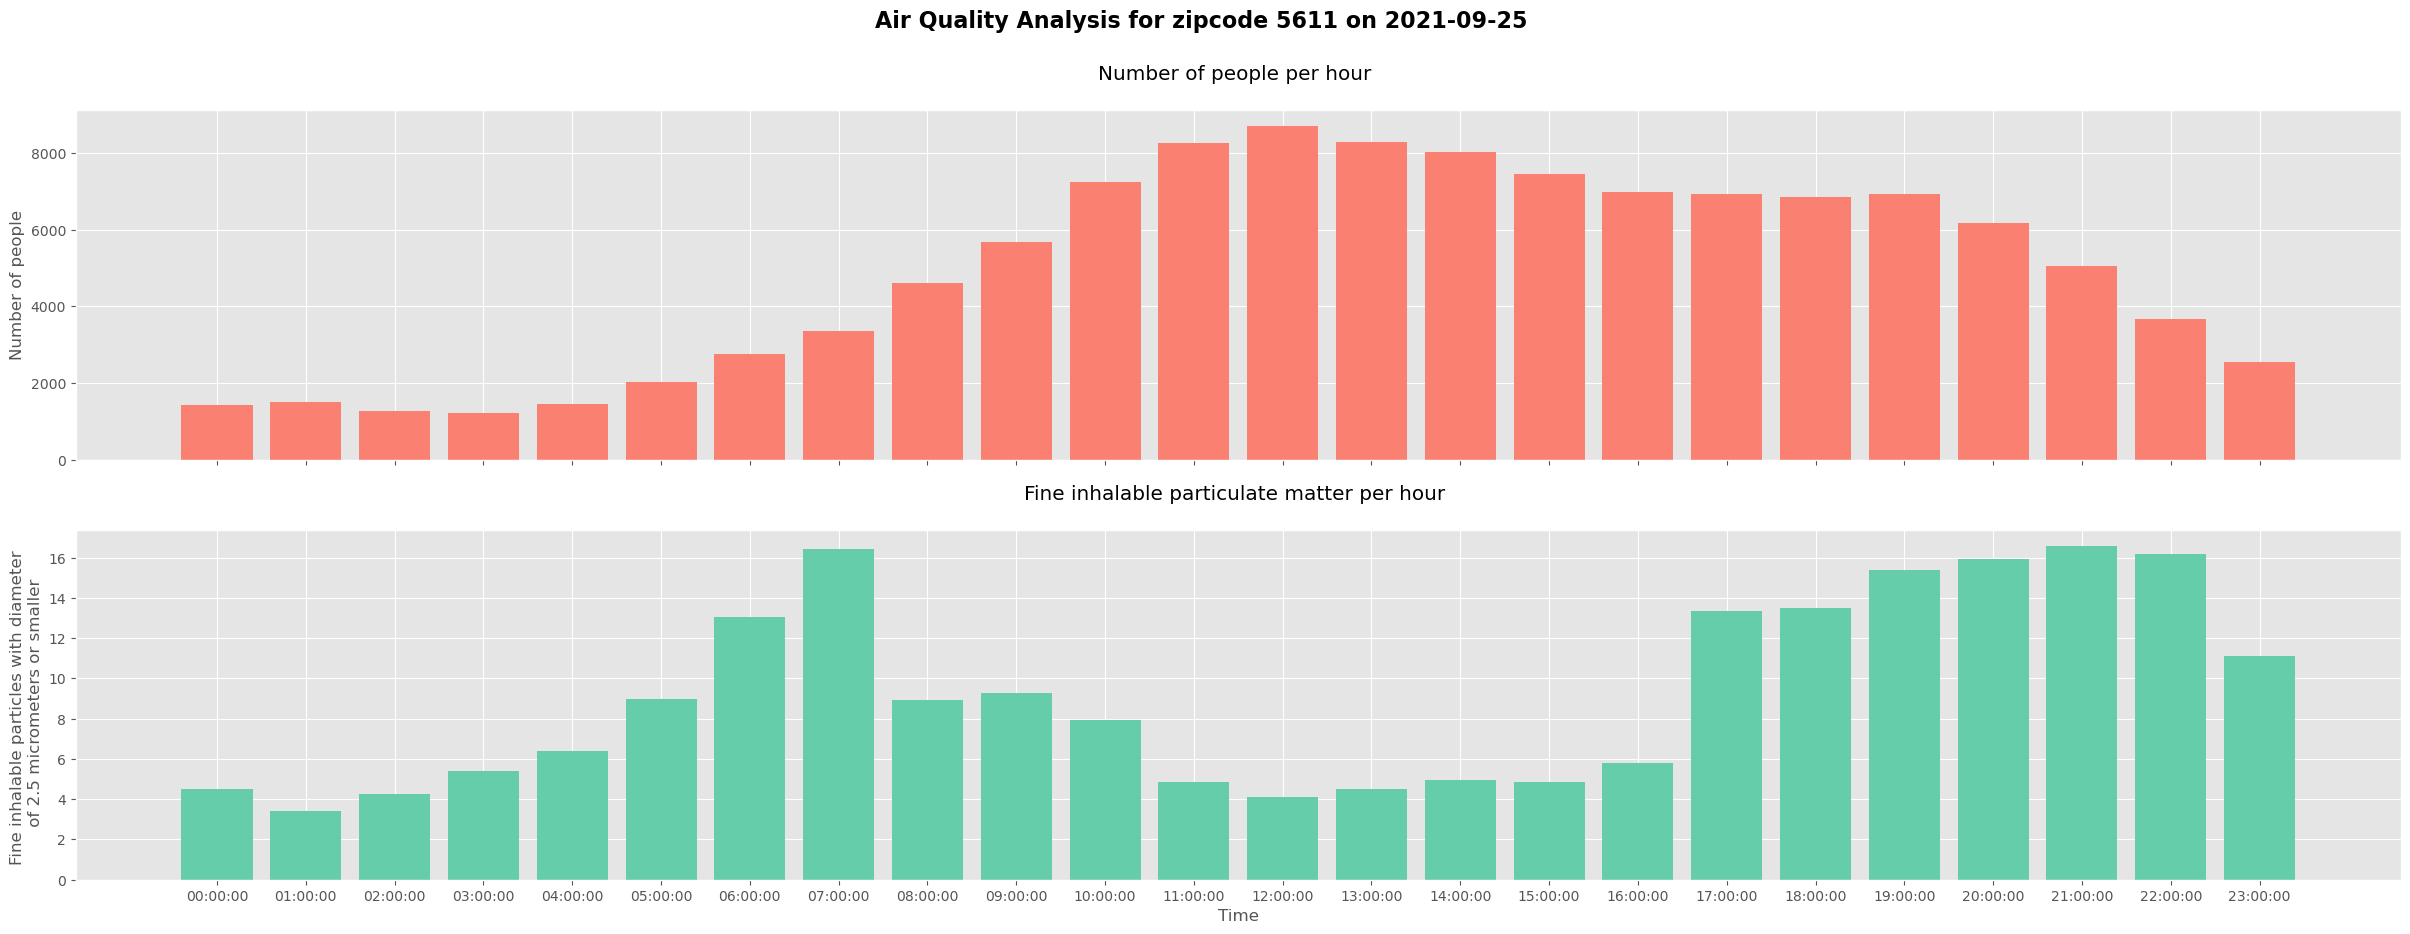

In [115]:
# Subplot of number of people, pollution, time
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 10),
                                sharex=True)

# Add data to ax0
ax0.bar(people_air_quality_area["time"], people_air_quality_area["pop_tot"], color="salmon");
# Add data to ax1
ax1.bar(people_air_quality_area["time"], people_air_quality_area["pm2.5"], color="mediumaquamarine");

# Customize ax0
ax0.set(title="Number of people per hour \n",
      ylabel="Number of people");

# Customize ax1
ax1.set(title="Fine inhalable particulate matter per hour \n",
        xlabel="Time",
        ylabel="Fine inhalable particles with diameter \n of 2.5 micrometers or smaller");

# Add a title to the figure
fig.suptitle("Air Quality Analysis for zipcode 5611 on 2021-09-25", fontsize=16, fontweight="bold");

<h4><font color=mediumvioletred> Get maximum, average and minimum fine inhalable particulate matter per zipcode </font></h4>

In [116]:
# Get daily average of pm2.5 per zipcode
average_pm_per_day = df_zichtop_air_pollution.groupby(["PC4", "date"])["pm2.5"].agg({"mean"}).reset_index()

# Get maximum, average and minimum of pm2.5 per zipcode
max_mean_min_pm = average_pm_per_day.groupby(["PC4"])["mean"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_pm.head()

,PC4,max,min,mean
0,5611,36.353814,2.800860,11.384660
1,5612,36.713622,2.803116,11.319719
2,5613,33.850463,2.651556,10.836317
3,5614,33.032114,2.573862,10.658091
4,5615,35.662240,2.660535,11.044525


<h4><font color=mediumvioletred> Visualize maximum, average and minimum fine inhalable particulate matter per zipcode </font></h4>

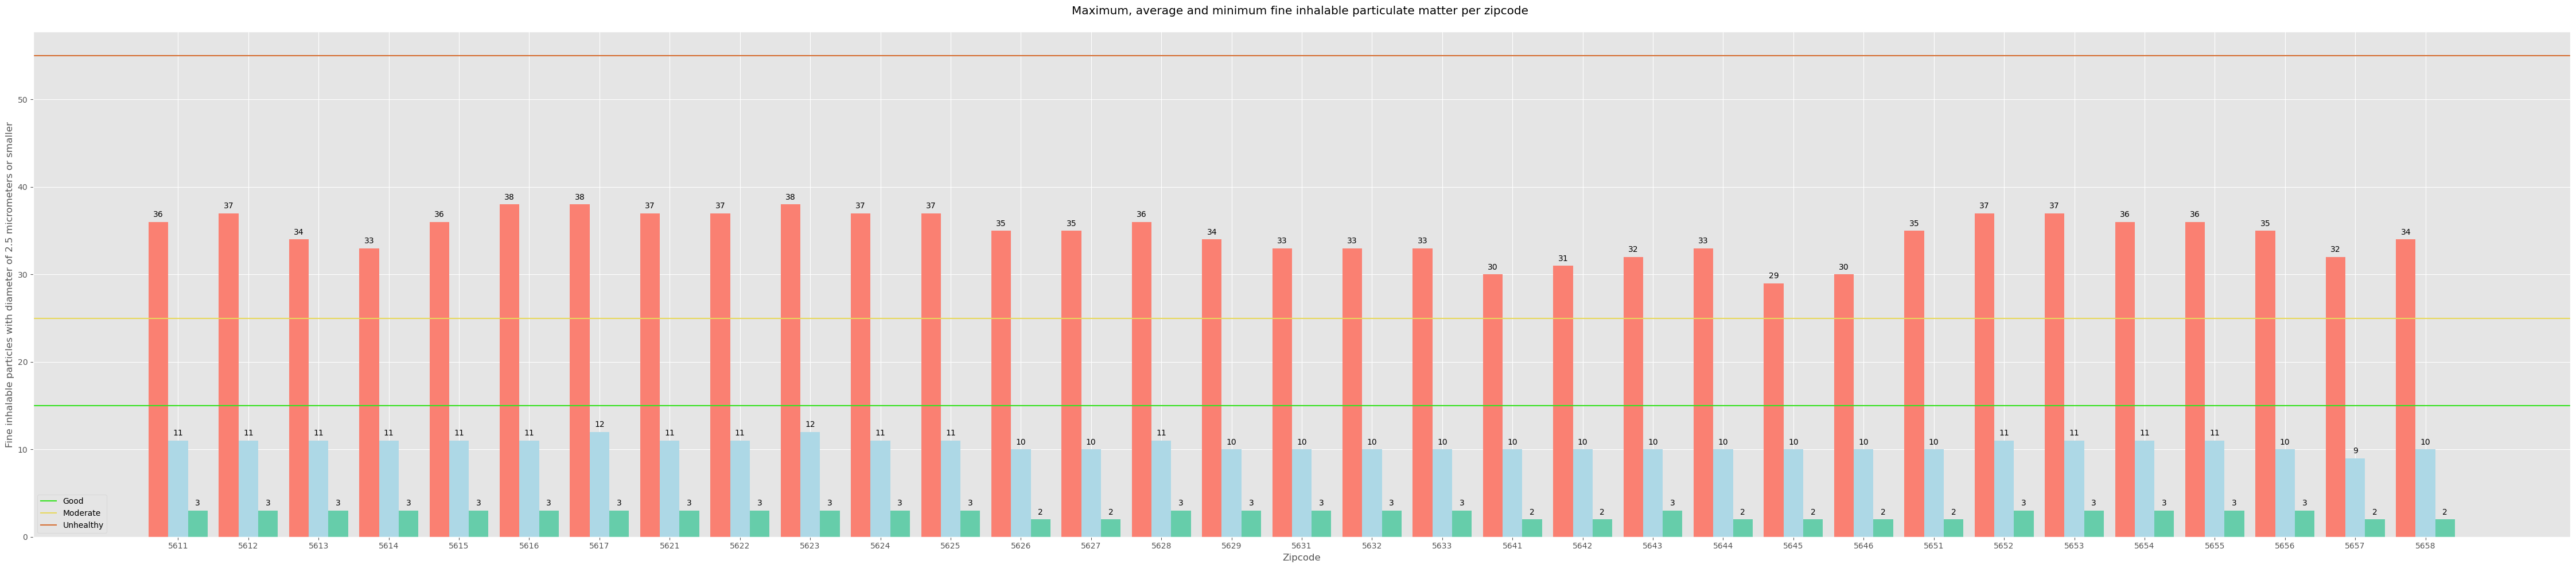

In [117]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_pm["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, round(max_mean_min_pm["max"]), width, label="Maximum", color="salmon")
rects2 = ax.bar(x, round(max_mean_min_pm["mean"]), width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, round(max_mean_min_pm["min"]), width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Fine inhalable particles with diameter of 2.5 micrometers or smaller")
ax.set_xlabel("Zipcode")
ax.set_title("Maximum, average and minimum fine inhalable particulate matter per zipcode \n")
ax.set_xticks(x, max_mean_min_pm["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

# adding air quality limits
good_limit = [15]
moderate_limit = [25]
unhealthy_limit = [55]

plt.axhline(y = good_limit, color = '#36e221', linestyle = '-')
plt.axhline(y = moderate_limit, color = '#e7d85d', linestyle = '-')
plt.axhline(y = unhealthy_limit, color = '#d56f33', linestyle = '-')
plt.legend(['Good', 'Moderate', 'Unhealthy'])

plt.show()

According to the following diagram the maximum pm2.5 for each zipcode are on a moderate/unhealthy level and the average and minimum pm2.5 are on a good level.

![title](images/pm2.5_chart.jpg)

<h4><font color=mediumvioletred>Specify country code in Pgeocode library </font></h4>

In [118]:
nomi = pgeocode.Nominatim('nl')

<h4><font color=mediumvioletred>Get postal code information for zipcode 5621 </font></h4>

In [119]:
nomi.query_postal_code("5621")

postal_code                5621
country_code                 NL
place_name            Eindhoven
state_name        Noord-Brabant
state_code                    6
county_name           Eindhoven
county_code                 772
community_name              NaN
community_code              NaN
latitude                51.4549
longitude                 5.457
accuracy                    6.0
Name: 0, dtype: object

<h4><font color=mediumvioletred>Get sample of of zichtop air pollution dataframe </font></h4>

In [120]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
42097,5657,2021-11-13 01:00:00,297,3.210353,95.0,0.0,0.0,0.0,83.0,36.0,83.0,2021-11-13,01:00:00
31893,5646,2021-10-03 21:00:00,733,2.363312,79.0,0.0,0.0,52.0,52.0,131.0,419.0,2021-10-03,21:00:00
31657,5645,2021-11-18 01:00:00,584,14.743526,20.0,0.0,0.0,0.0,0.0,0.0,564.0,2021-11-18,01:00:00
17460,5627,2021-10-07 12:00:00,4990,3.923208,619.0,129.0,297.0,284.0,1367.0,774.0,1520.0,2021-10-07,12:00:00
41844,5657,2021-11-02 12:00:00,4358,4.765103,758.0,114.0,294.0,445.0,1118.0,1525.0,104.0,2021-11-02,12:00:00


<h4><font color=mediumvioletred>Create a new dataframe containing unique zipcodes </font></h4>

In [121]:
zipcodes = pd.DataFrame({"PC4": df_zichtop_air_pollution["PC4"].unique()})
zipcodes.head(5)

,PC4
0,5611
1,5612
2,5613
3,5614
4,5615


<h4><font color=mediumvioletred>Add latitude, longitude data to the zipcodes dataframe </font></h4>

In [122]:
# add latitude, longitude data to the dataframe
zipcodes["latitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
zipcodes["longitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [123]:
zipcodes["PC4"] = zipcodes["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of zipcodes </font></h4>

In [124]:
zipcodes.sample(5)

,PC4,latitude,longitude
22,5644,51.4183,5.4887
31,5657,51.4512,5.4008
20,5642,51.4389,5.5144
13,5627,51.4853,5.4440
19,5641,51.4466,5.5198


<h4><font color=mediumvioletred>Plot the map with the latitude, longitude and zipcode in Eindhoven</font></h4>

In [125]:
fig = px.scatter_mapbox(zipcodes, 
                        title="Eindhoven map with latitude, longitude and zipcode", 
                        lat="latitude", 
                        lon="longitude", 
#                         text="PC4", 
                        hover_name="PC4", 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>Get min and max number of people per area</font></h4>

In [126]:
min_max_people_per_area = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min"]).rename(columns={'max': 'max_number_people', "min": "min_number_people"}).reset_index()
min_max_people_per_area.head(5)

,PC4,max_number_people,min_number_people
0,5611,11617,708
1,5612,10250,737
2,5613,5925,537
3,5614,3504,217
4,5615,4408,394


<h4><font color=mediumvioletred>Add latitude, longitude data to the min_max_people_per_area dataframe </font></h4>

In [127]:
min_max_people_per_area["latitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
min_max_people_per_area["longitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [128]:
min_max_people_per_area["PC4"] = min_max_people_per_area["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of min_max_people_per_area </font></h4>

In [129]:
min_max_people_per_area.sample(5)

,PC4,max_number_people,min_number_people,latitude,longitude
4,5615,4408,394,51.4293,5.4746
3,5614,3504,217,51.4284,5.4921
31,5657,7759,143,51.4512,5.4008
10,5624,4101,648,51.4696,5.4570
29,5655,3005,476,51.4152,5.4399


<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zipcode, minimum and maximum number of people in Eindhoven</font></h4>

In [130]:
fig = px.scatter_mapbox(min_max_people_per_area, 
                        title="Eindhoven map with latitude, longitude, zipcode, maximum and minimum number of people", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        hover_data=["min_number_people"], 
                        color="max_number_people", 
                        size="max_number_people", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>Calculate number of people per hour </font></h4>

In [131]:
# Get specific columns
people_per_hour = df_zichtop_air_pollution.iloc[:, [0, 3, 4, 5, 11, 12]].copy()
# Calculate number of people per hour
people_per_hour["people_number"] = people_per_hour["m00_30"] + people_per_hour["m30_60"]

people_per_hour.head(5)

,PC4,pm2.5,m00_30,m30_60,date,time,people_number
0,5611,4.531522,155.0,0.0,2021-09-25,00:00:00,155.0
1,5611,3.434374,130.0,0.0,2021-09-25,01:00:00,130.0
2,5611,4.274056,44.0,0.0,2021-09-25,02:00:00,44.0
3,5611,5.396931,14.0,0.0,2021-09-25,03:00:00,14.0
4,5611,6.389200,56.0,0.0,2021-09-25,04:00:00,56.0


<h4><font color=mediumvioletred>People vs. pollution on 25-09-2021 </font></h4>

In [132]:
# Calculate people number (sum) and pm2.5 (average) per day
people_pollution_per_day = people_per_hour[people_per_hour.date == "2021-09-25"].groupby(["PC4", "date"]).agg({"people_number": "sum", "pm2.5": "mean"}).reset_index()
# Round to 2 decimal places
people_pollution_per_day = people_pollution_per_day.round(decimals=2)

people_pollution_per_day.head(5)

,PC4,date,people_number,pm2.5
0,5611,2021-09-25,16501.0,9.16
1,5612,2021-09-25,23022.0,9.18
2,5613,2021-09-25,14987.0,8.56
3,5614,2021-09-25,10039.0,8.45
4,5615,2021-09-25,11540.0,8.97


<h4><font color=mediumvioletred>Add latitude, longitude data to the people_pollution_per_day dataframe </font></h4>

In [133]:
people_pollution_per_day["latitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
people_pollution_per_day["longitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [134]:
people_pollution_per_day["PC4"] = people_pollution_per_day["PC4"].astype("str")

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zipcode, number of people and fine inhalable particulate matter in Eindhoven</font></h4>

In [135]:
fig = px.scatter_mapbox(people_pollution_per_day, 
                        title="Number of people vs. fine inhalable particulate matter per zipcode in Eindhoven on 25-09-2021", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        color="pm2.5", 
                        size="people_number", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred> Conclusion </font></h4>

After exploring and visualizing the zichtop dataset, we conclude that the only relevant columns to use in the following steps are  date, PC4 (zipcode) and a new column called people_number (m00_30 + m30_60).

We need this new column because we want to group data per area and date and currently pop_tot column is the result of the sum of the following columns (m00_30, m30_60, H1_2, H2_4, H4_8, H8_16 and H16plus), so the same people are counted multiple times throughout the day and that will result in inaccurate number of people. 

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>